In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import requests

In [5]:
url =  "https://www.mit.edu/~ecprice/wordlist.10000"
words = response = requests.get(url).text.splitlines()
random.sample(words, 10)

['primarily',
 'buzz',
 'attempts',
 'continually',
 'eyes',
 'theorem',
 'skills',
 'everyday',
 'improving',
 'cafe']

In [15]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)


In [7]:
block_size = 3 

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] 

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [ ]:

# reliably train large networks.
# problem is dynamic range of layers

# for small networks scaling initialisation
# for large networks batch norm

# adjust hidden layer weights so they are not too small or too large (saturating the activation)

# coupling together of batches -> conversely helps avoid overfitting by introducing uncertainty
# other normalisations without coupling, but its hard because of the regularising effect.

# bn to control statistics in neural net
# common to place after linear layers


In [8]:
# Batch Normalisation

# initialisation

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])  
Xte,  Yte  = build_dataset(words[n2:])   

# MLP 
n_embd = 10 
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647) 

C  = torch.randn((vocab_size, n_embd), generator=g) # produces embeddings
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # initialisation for tanh 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0


bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) 
for p in parameters:
  p.requires_grad = True
  

torch.Size([60647, 3]) torch.Size([60647])
torch.Size([7759, 3]) torch.Size([7759])
torch.Size([7474, 3]) torch.Size([7474])
12097


In [21]:
C.shape

torch.Size([27, 10])

      0/ 200000: 3.2885
  10000/ 200000: 1.8856
  20000/ 200000: 2.2291
  30000/ 200000: 1.9903
  40000/ 200000: 2.2404
  50000/ 200000: 2.0527
  60000/ 200000: 1.7907
  70000/ 200000: 2.4621
  80000/ 200000: 1.9275
  90000/ 200000: 1.8402
 100000/ 200000: 1.8559
 110000/ 200000: 2.1469
 120000/ 200000: 2.2198
 130000/ 200000: 1.8929
 140000/ 200000: 2.1060
 150000/ 200000: 2.0103
 160000/ 200000: 1.9261
 170000/ 200000: 2.0518
 180000/ 200000: 2.3385
 190000/ 200000: 1.7945


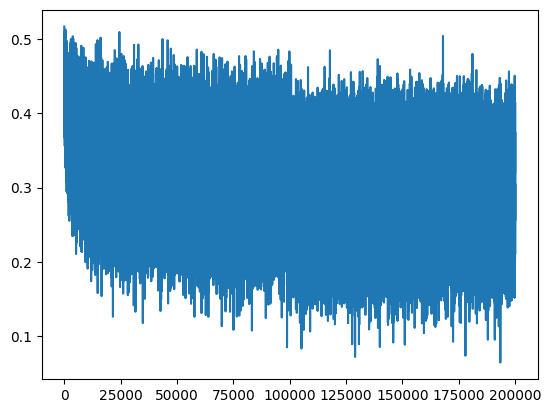

In [9]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors, each trigam -> vector dim=30
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 # hidden layer pre-activation
  
  # bn layer
  # normalising hidden states roughly gaussian with std dev 1 upto scale and shift
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  # low momentum running mean estimation
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

plt.plot(lossi)

In [20]:
emb.shape, Xb.shape, emb.view(emb.shape[0], -1)

(torch.Size([1, 3, 10]),
 torch.Size([32, 3]),
 tensor([[-0.7069,  0.3187,  0.3088, -1.7511, -0.4880,  2.0496, -1.2675, -0.7265,
          -2.2964,  0.0408,  0.3165, -1.6721,  1.4095, -0.7799,  0.3963,  1.0871,
           0.4351, -0.6269, -0.3034, -1.0398,  0.0951,  2.1149, -0.7457,  0.2580,
          -1.9923,  1.2250,  0.5484,  1.5589,  0.3276,  1.1112]],
        grad_fn=<ViewBackward0>))

In [10]:
# calibrate the batch norm at the end of training
# neural net takes in batches, how to feed in a single example
# measure the mean/std over the entire training set

with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

@torch.no_grad() 
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9287593364715576
val 2.096768617630005


In [14]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 # + b1
      hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      if ix == 0:
        break
      out.append(ix)
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mring
myangerent
dury
porthurs
bad
log
adered
eling
minoen
edecias
passendles
hotel
noshugers
highest
tuirecepting
puction
pred
regislement
rease
stourning
